In [131]:
import pyspark
from pyspark import SparkContext
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [123]:
sc = SparkContext.getOrCreate()

In [148]:
cols = ['x','y','label']
df = pd.read_csv('Aggregation.txt', sep = '\t', header=None, names=cols)
df.head()

,x,y,label
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2
3,14.15,28.80,2
4,13.75,28.05,2


<AxesSubplot:xlabel='0', ylabel='1'>

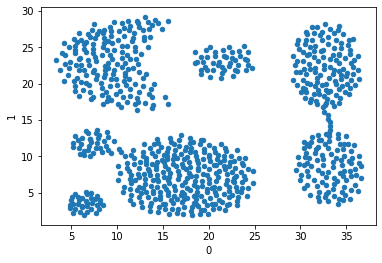

In [125]:
df.plot(x=0,y=1,kind='scatter')

In [126]:
x = df[0].to_list()
y = df[1].to_list()
points = np.array(list(zip(x,y)))

In [129]:
def kMap(x, mu):
    distances = np.zeros((mu.shape[0]))
    for i in range(mu.shape[0]):
        distances[i] = np.linalg.norm(x-mu[i])
    return (np.argmin(distances), (x, 1))

In [12]:
def kReduce(x):
    x = list(x)
    return [sum(i) for i in zip(*x)]

In [67]:
def means(x):
    x = list(x)
    return x[0][0] / x[0][1]

In [103]:
def getCentroidsFromTup(x):
    return np.array([i[1] for i in x])

In [178]:
def toList(x):
    l = []
    for i in x:
        l.append([i[1][0][0], i[1][0][1],i[0]])
    return l

In [203]:
def plot(clusters):
    l = toList(clusters.collect())
    df_clust = pd.DataFrame(l, columns = cols)
    ax = sns.scatterplot(data=df_clust,x='x', y='y', hue='label',palette="deep")
    plt.show()

In [207]:
def KMeans(x, k):
    centroids = x[np.random.choice(x.shape[0], k, replace=False), :]
    x = sc.parallelize(x)
    while 1:
        step0 = x.map(lambda x: kMap(x, centroids))
        plot(step0)
        step1 = step0.groupByKey().mapValues(lambda x: kReduce(x))
        new_centroids = getCentroidsFromTup(step1.groupByKey().mapValues(lambda x: means(x)).collect())
        if np.all(new_centroids != centroids):
            centroids = new_centroids
        else:
            return centroids, step0.collect()
    

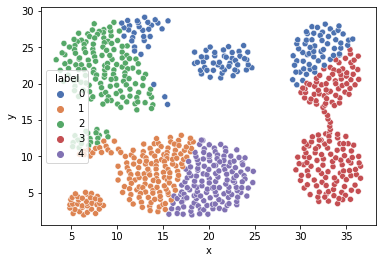

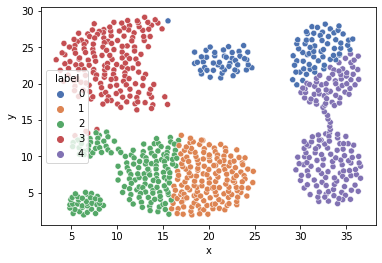

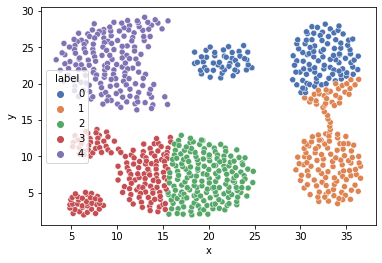

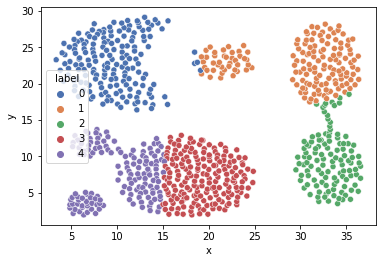

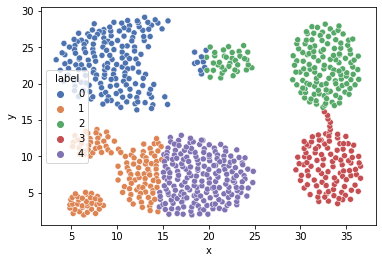

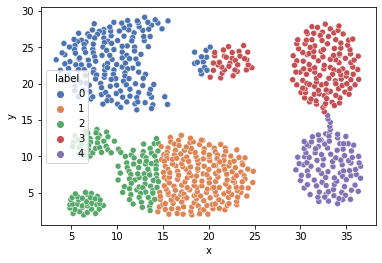

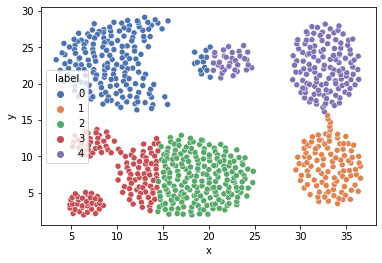

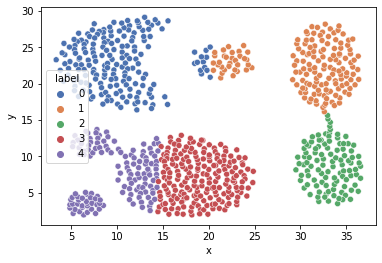

In [211]:
cent, clusters = KMeans(points,5)